In [1]:
import networkx as nx
from ema_workbench import load_results
import matplotlib.pyplot as plt
import pandas as pd
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import feature_scoring
from SALib.analyze import sobol
import pickle
import seaborn as sns

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'graph_tool', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


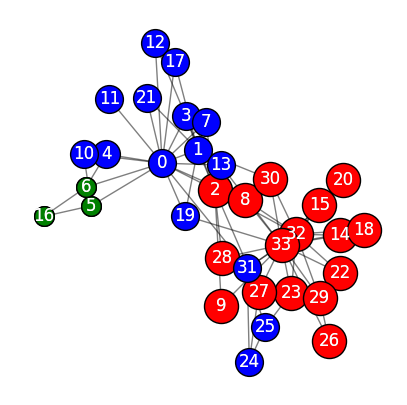

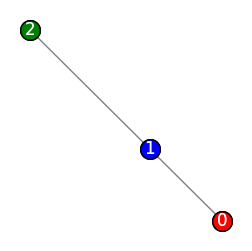

In [2]:
from cdlib import algorithms
from cdlib import viz

g = nx.karate_club_graph()
lp_coms = algorithms.label_propagation(g)

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(5, 5), plot_overlaps=True, plot_labels=True) #, top_k=2)
viz.plot_community_graph(g, lp_coms, figsize=(3, 3), plot_overlaps=False, plot_labels=True)
plt.show()

In [3]:
from sklearn_extra.cluster import KMedoids

# NOTEBOOK CONFIGURATION
PROJECT_NAME = "jpetstore"
PROJECT_PATH = "../jpetstore"

In [4]:
MODEL_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_128scenarios_nopolicies_sobol" #.tar.gz'

experiments_df, outcomes = load_results(MODEL_FILENAME+ '.tar.gz')
outcomes_df = pd.DataFrame(outcomes)
print(experiments_df.shape, outcomes_df.shape)

with open(MODEL_FILENAME+'_model.pkl', 'rb') as input:
    uncertainties_problem = pickle.load(input)
with open(MODEL_FILENAME+'_partitions.pkl', 'rb') as input:
    partitions_dict = pickle.load(input)
    print(len(partitions_dict.keys()), "clusters")

(768, 5) (768, 5)
496 clusters


In [5]:
experiments_df.head()

,k,resolution,scenario,policy,model
0,1,0.730859,0,NaN,jpetstore
1,13,0.730859,1,NaN,jpetstore
2,1,0.463672,2,NaN,jpetstore
3,1,0.463672,3,NaN,jpetstore
4,13,0.730859,4,NaN,jpetstore


In [6]:
experiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   k           768 non-null    int64   
 1   resolution  768 non-null    float64 
 2   scenario    768 non-null    category
 3   policy      0 non-null      category
 4   model       768 non-null    category
dtypes: category(3), float64(1), int64(1)
memory usage: 37.5 KB


In [7]:
experiments_df.describe()

,k,resolution
count,768.000000,768.000000
mean,21.000000,1.050000
std,11.820032,0.548823
min,1.000000,0.107422
25%,11.000000,0.578711
50%,21.000000,1.050000
75%,31.000000,1.521289
max,41.000000,1.992578


In [8]:
outcomes

{'n_partitions': array([ 5.,  6.,  5.,  6.,  4.,  6.,  6.,  7.,  5.,  5.,  6.,  5.,  7.,
         7.,  4.,  4.,  6.,  5.,  4.,  4.,  7.,  7.,  4.,  7.,  9.,  8.,
         6.,  7.,  7.,  7.,  6.,  5.,  4.,  4.,  6.,  4.,  4.,  4.,  4.,
         5.,  4.,  5.,  7.,  7.,  8.,  8.,  6.,  8., 10., 11.,  6.,  5.,
        11.,  7.,  5.,  4.,  5.,  7.,  4.,  6.,  7.,  7., 11.,  9.,  4.,
         9.,  5.,  6.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,  5.,  4.,  5.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  6.,  6.,  7.,  7.,  5.,
         5.,  4.,  4.,  5.,  4.,  5.,  5.,  5.,  5.,  7.,  4.,  4.,  5.,
         8.,  7.,  5.,  7.,  4.,  5.,  6.,  6.,  5.,  6.,  7.,  7.,  4.,
         4.,  7.,  4.,  4.,  4.,  4.,  5.,  4.,  4.,  7.,  5.,  7.,  9.,
         4.,  6.,  7.,  9.,  7.,  7., 12.,  7.,  5.,  4.,  4.,  5.,  5.,
         7.,  5.,  4.,  6.,  6.,  4.,  7.,  7.,  7.,  4.,  4.,  8.,  4.,
         7.,  7.,  5.,  5.,  4.,  5.,  5.,  5.,  7.,  7.,  5.,  5.,  6.,
         7., 10.,  8.,  9.,  8.,  4

In [9]:
outcomes_df.head()

,n_partitions,modularity,ned,density,noise_classes
0,5.0,0.005986,0.250,4.734021,17.0
1,6.0,0.015981,0.750,5.400916,17.0
2,5.0,-0.008603,0.250,6.650172,17.0
3,6.0,-0.010357,0.292,6.340206,17.0
4,4.0,0.016438,0.000,4.347570,17.0


In [10]:
outcomes_df.describe()

,n_partitions,modularity,ned,density,noise_classes
count,768.000000,768.000000,768.000000,768.000000,768.0
mean,5.723958,0.015366,0.438395,5.593807,17.0
std,1.542733,0.006377,0.309646,1.046223,0.0
min,4.000000,-0.028480,0.000000,3.594221,17.0
25%,4.000000,0.013706,0.167000,4.508591,17.0
50%,5.000000,0.016438,0.500000,5.523024,17.0
75%,7.000000,0.018251,0.750000,6.340206,17.0
max,12.000000,0.026736,1.000000,8.547537,17.0


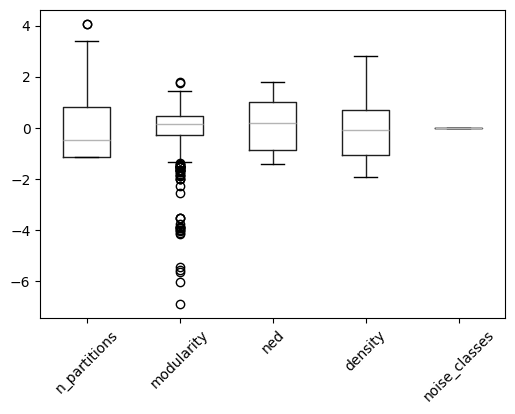

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
outcomes_scaled = scaler.fit_transform(outcomes_df)
outcomes_scaled_df = pd.DataFrame(outcomes_scaled, columns=outcomes_df.columns)

boxplot = outcomes_scaled_df.boxplot(grid=False, figsize=(6,4), rot=45)
plt.show()

In [12]:
df = pd.concat([experiments_df, outcomes_df], axis=1) #outcomes_df.copy()
#df['resolution'] = experiments_df['resolution']

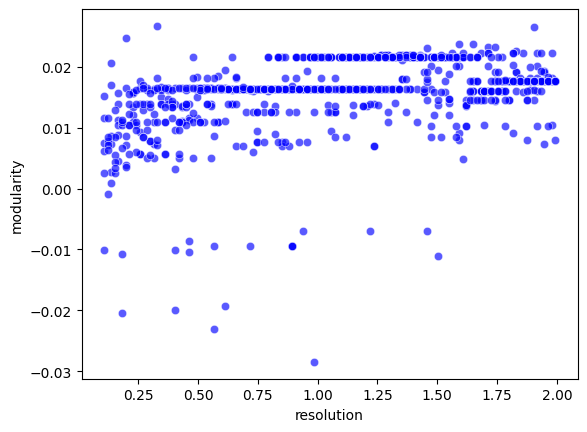

In [13]:
sns.scatterplot(data=df, x="resolution", y="modularity", alpha=0.65, color='blue')
plt.show()

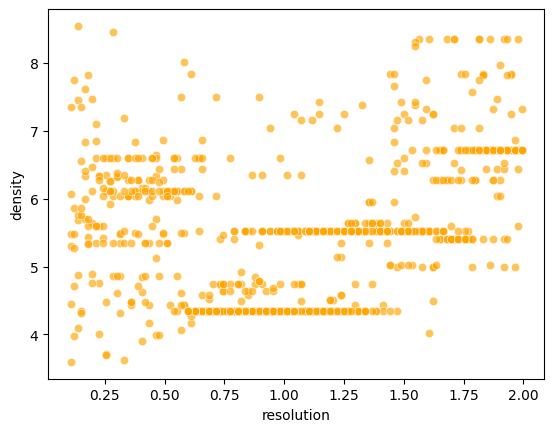

In [14]:
sns.scatterplot(data=df, x="resolution", y="density", alpha=0.65, color='orange')
plt.show()

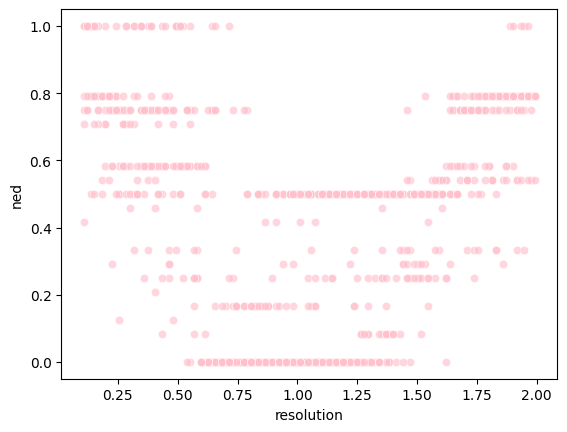

In [15]:
sns.scatterplot(data=df, x="resolution", y="ned", alpha=0.65, color='pink')
plt.show()

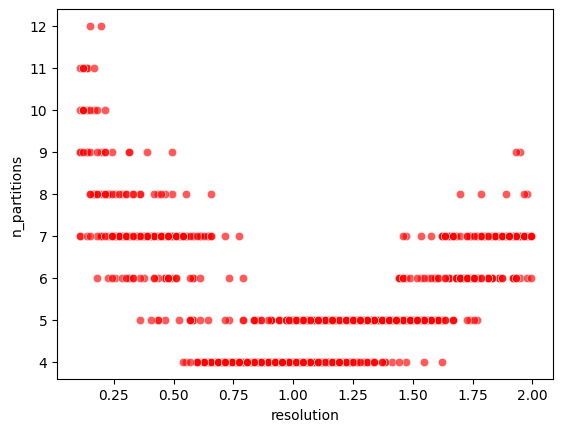

In [16]:
sns.scatterplot(data=df, x="resolution", y="n_partitions", alpha=0.65, color='red')
plt.show()

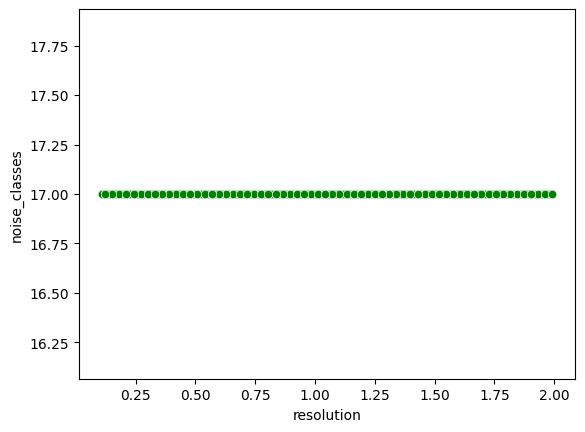

In [17]:
sns.scatterplot(data=df, x="resolution", y="noise_classes", alpha=0.65, color='green')
plt.show()

In [18]:
# Visualization of scenarios
def show_pairplot(experiments, outcomes, kind='sns', title='', group='scenario', filename=None):
    if kind == 'sns':
        data = pd.DataFrame(outcomes)
        policies = experiments['scenario']
        data['scenario'] = policies
        g = sns.pairplot(data, hue=group, vars=list(outcomes.keys()), corner=True, plot_kws={'alpha':0.25})
        g._legend.remove()
        g.fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()
    if kind == 'matplotlib':
        data = experiments.copy()
        data['scenario'] = experiments['scenario'].astype(str)
        fig, axes = pairs_plotting.pairs_scatter(data, outcomes, group_by=group,legend=False)
        fig.set_size_inches(8,8)
        fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()

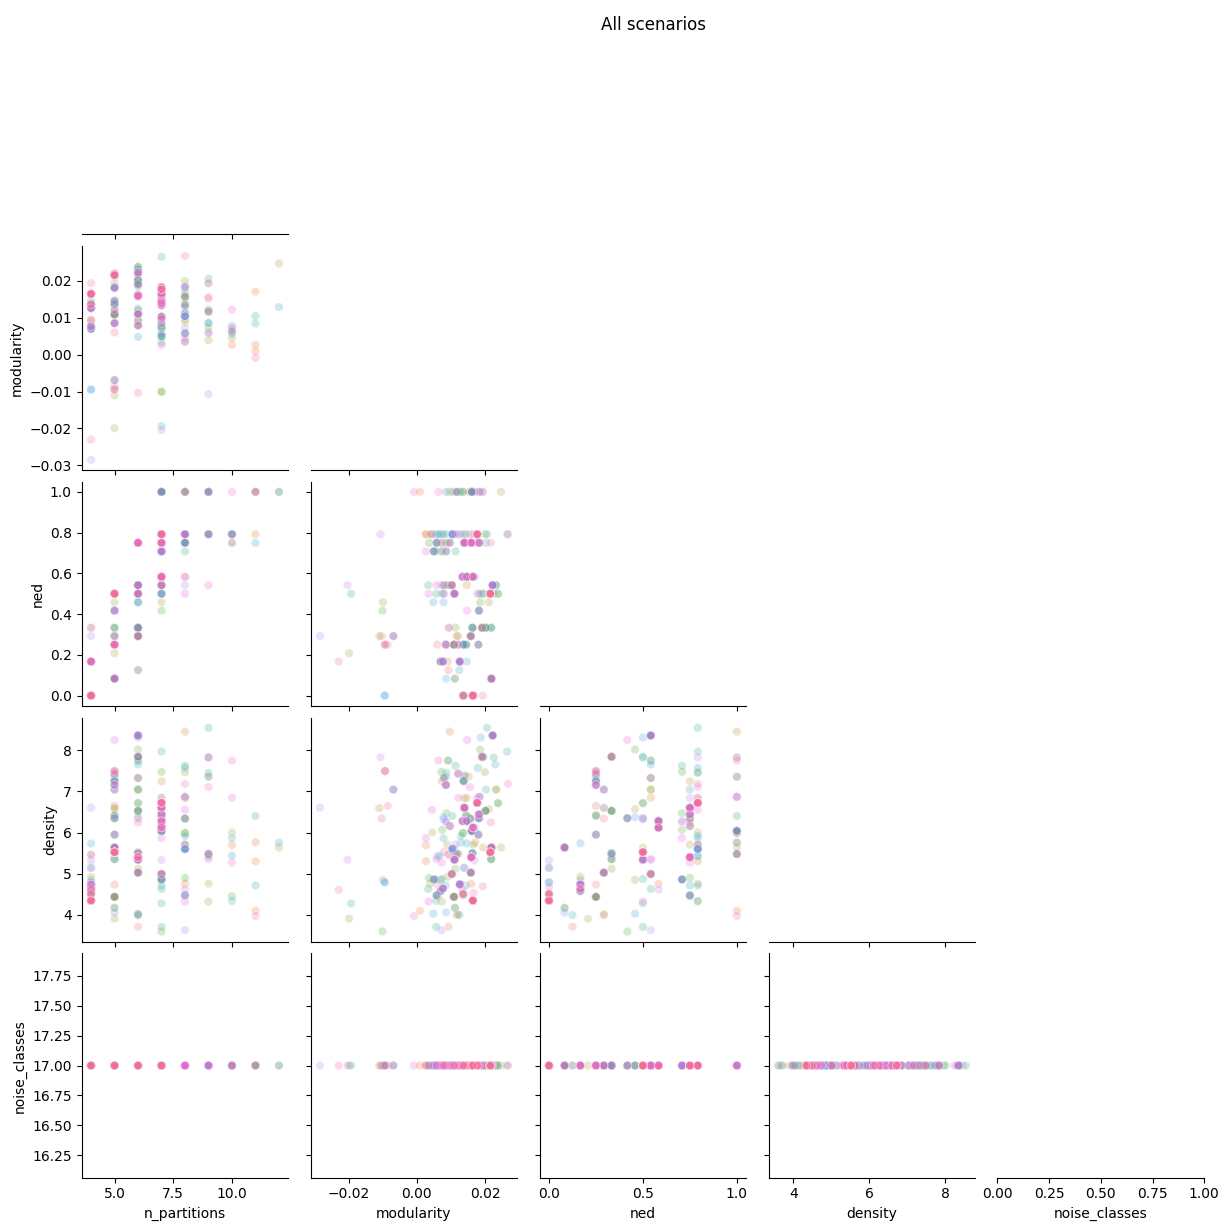

In [19]:
show_pairplot(experiments_df, outcomes, title='All scenarios', kind='sns')

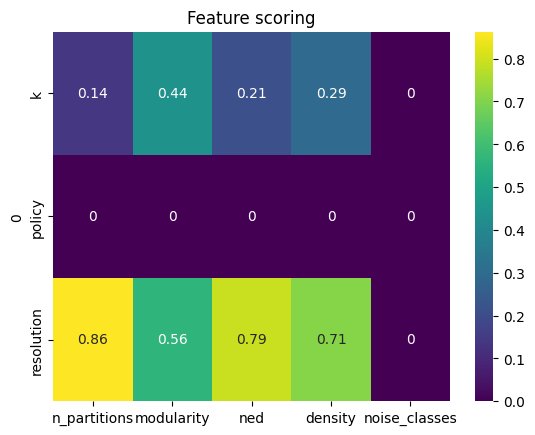

,n_partitions,modularity,ned,density,noise_classes
0,,,,,
k,0.136706,0.438968,0.210376,0.294075,0.0
policy,0.000000,0.000000,0.000000,0.000000,0.0
resolution,0.863294,0.561032,0.789624,0.705925,0.0


In [20]:
fs = feature_scoring.get_feature_scores_all(experiments_df, outcomes) #, mode=feature_scoring.CLASSIFICATION)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.title('Feature scoring')
#plt.title('Feature scoring (jpetstore)')
#plt.savefig('feature-scoring-jpetstore.png')
#plt.title('Feature scoring (cargo)')
#plt.savefig('feature-scoring-cargo.png')
plt.show()
fs

In [21]:
# For parameters
# uncertainties_problem = get_SALib_problem(model.uncertainties)
print('----', 'n_partitions')
Si_1 = sobol.analyze(uncertainties_problem, outcomes['n_partitions'], calc_second_order=True, print_to_console=True)
print('----', 'modularity')
Si_2 = sobol.analyze(uncertainties_problem, outcomes['modularity'], calc_second_order=True, print_to_console=True)
print('----', 'ned')
ned = sobol.analyze(uncertainties_problem, outcomes['ned'], calc_second_order=True, print_to_console=True)
print('----', 'density')
density = sobol.analyze(uncertainties_problem, outcomes['density'], calc_second_order=True, print_to_console=True)
print('----', 'noise_classes')
Si_3 = sobol.analyze(uncertainties_problem, outcomes['noise_classes'], calc_second_order=True, print_to_console=True)

---- n_partitions
                  ST   ST_conf
k           0.245142  0.072806
resolution  0.921520  0.217990
                  S1   S1_conf
k          -0.053066  0.162886
resolution  0.682174  0.263133
                       S2   S2_conf
[k, resolution]  0.118228  0.196139
---- modularity
                  ST   ST_conf
k           0.774974  0.342081
resolution  0.522928  0.247693
                 S1   S1_conf
k           0.31298  0.413361
resolution  0.26973  0.181081
                       S2   S2_conf
[k, resolution] -0.131644  0.460117
---- ned
                  ST   ST_conf
k           0.450133  0.137042
resolution  0.951707  0.203920
                  S1   S1_conf
k           0.056213  0.189236
resolution  0.572551  0.235548
                       S2   S2_conf
[k, resolution]  0.019191  0.222869
---- density
                  ST   ST_conf
k           0.576433  0.175504
resolution  0.958934  0.221319
                  S1   S1_conf
k           0.081699  0.151572
resolution  0.2179

In [22]:
def show_sobol(problem, Si, title='', filename=None):
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

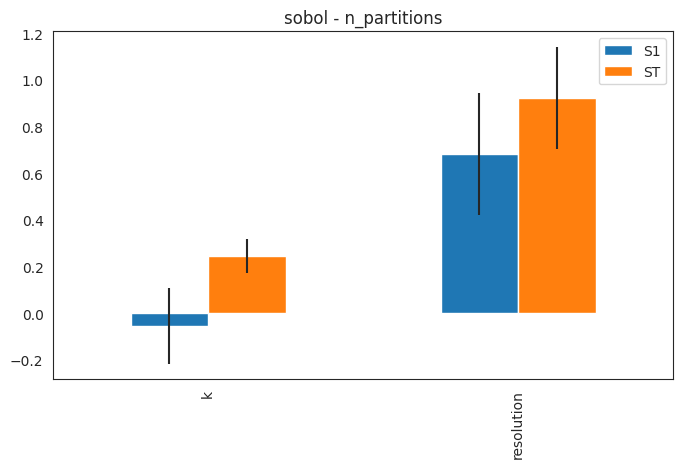

In [23]:
show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions')
#show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions (jpetstore)', filename="sobol_n_partitions_jpetstore.png")
#show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions (cargo)', filename="sobol_n_partitions_cargo.png")

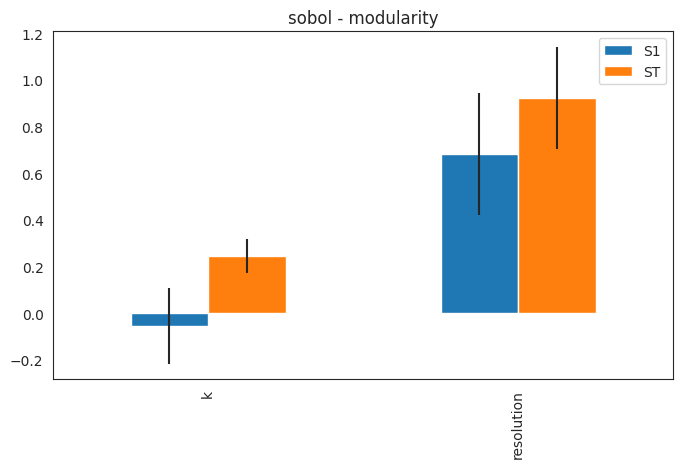

In [24]:
show_sobol(uncertainties_problem, Si_1, title='sobol - modularity')
#show_sobol(uncertainties_problem, Si_1, title='sobol - modularity (jpetstore)', filename="sobol_modularity_jpetstore.png")
#show_sobol(uncertainties_problem, Si_1, title='sobol - modularity (cargo)', filename="sobol_modularity_cargo.png")

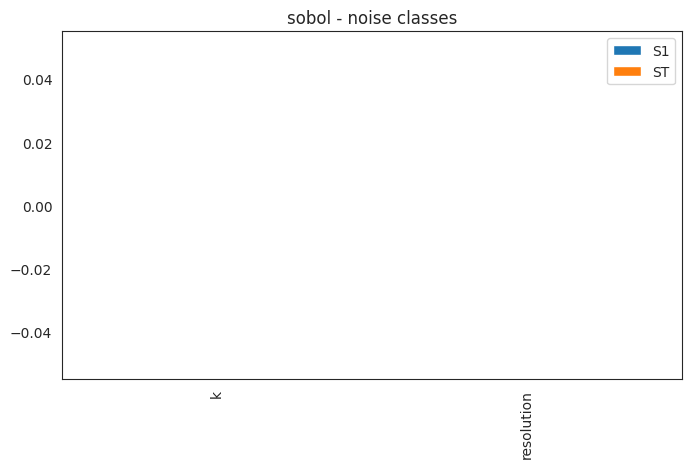

In [25]:
show_sobol(uncertainties_problem, Si_3, title='sobol - noise classes')
#show_sobol(uncertainties_problem, Si_3, title='sobol - modularity (jpetstore)', filename="sobol_noiseclasses_jpetstore.png")
#show_sobol(uncertainties_problem, Si_3, title='sobol - modularity (cargo)', filename="sobol_noiseclasses_cargo.png")

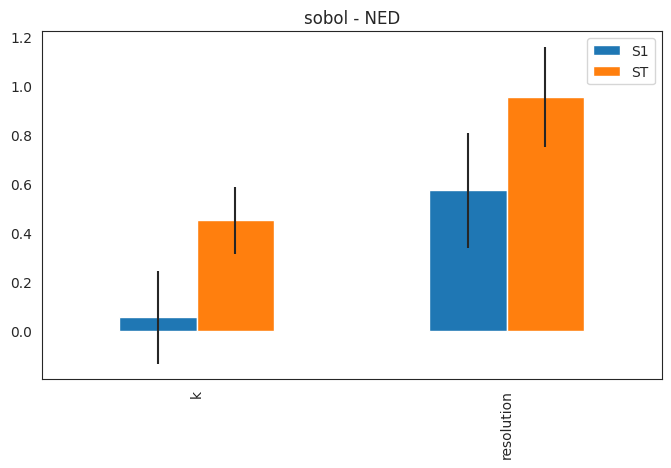

In [26]:
show_sobol(uncertainties_problem, ned, title='sobol - NED')

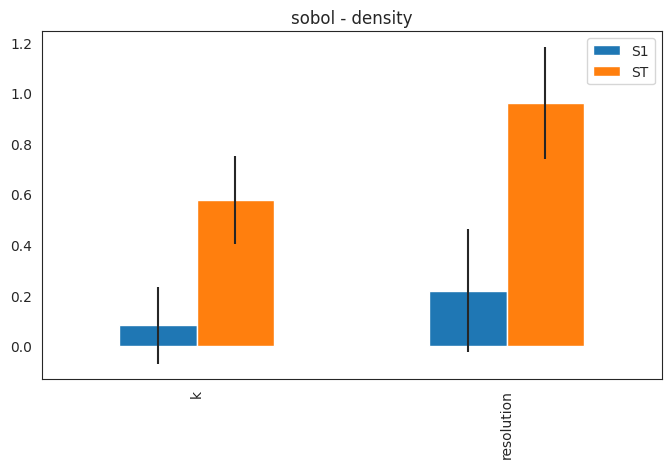

In [27]:
show_sobol(uncertainties_problem, density, title='sobol - density')

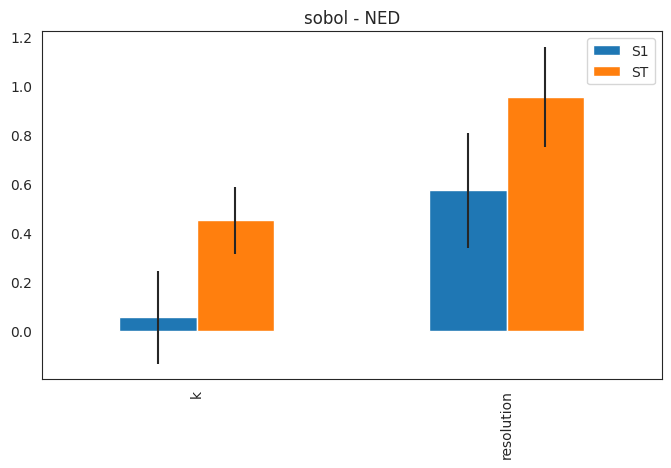

In [28]:
show_sobol(uncertainties_problem, ned, title='sobol - NED')

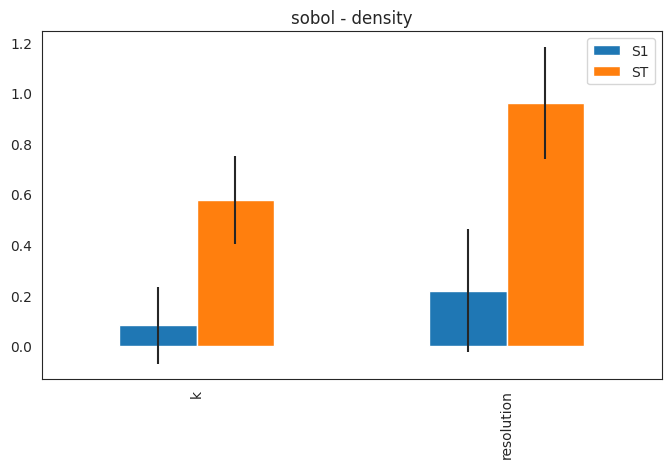

In [29]:
show_sobol(uncertainties_problem, density, title='sobol - density')

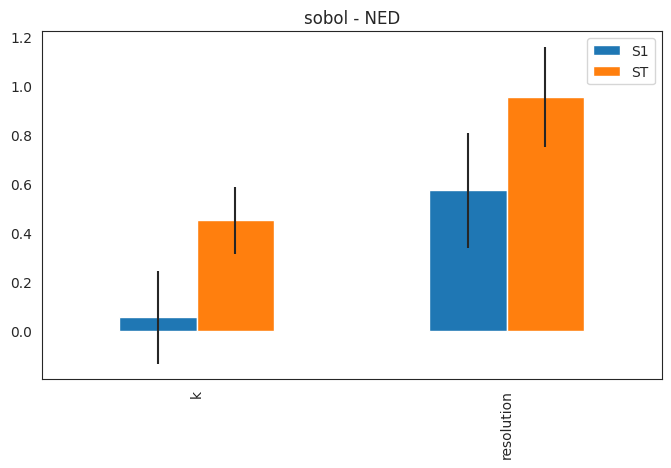

In [30]:
show_sobol(uncertainties_problem, ned, title='sobol - NED')

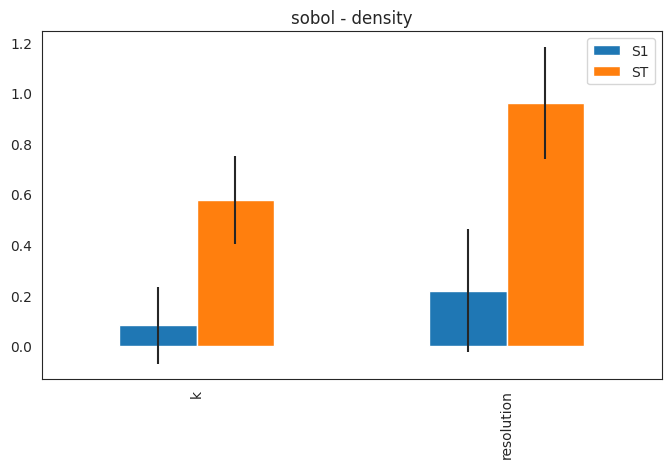

In [31]:
show_sobol(uncertainties_problem, density, title='sobol - density')